# Confidence Intervals & Bootstrap

In [ ]:
# Add the necessary imports for this homework 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from scipy.stats import t
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# To suppress unecessary warnings:

import warnings
warnings.filterwarnings(action = 'ignore')

Load in the `hockey_draftees_2005.csv` data into pandas. It contains data from hockey players drafted in 2005, including their age (age - in years), weight (wt - in pounds), height (ht - in inches), and overall ability (overall, ranked on a combined scale, with higher values being better). 

Perform the following actions:
1. Fit a linear model of the influence of weight (`wt`) on the overall ability (`overall`) using a quadratic regression model from sklearn.  Call your fitted model `model`.  
2. Make a scatter plot of the weight (x-axis) against overall (y-axis). Be sure to label the plot axes.
3. Plot the predicted values for the overall ability for 170-250 pounds as a line plot. 
4. Calculate the r-squared value for this fit directly from the residuals (not using the built-in function).

In [ ]:
# Loading in the csv file:

csv = pd.read_csv("hockey_draftees_2005.csv")
csv.head(3)

,rnd,overall,draftteam,player,pos,country,wt,ht,draftyear,age,gp,playerurl
0,1,1,PIT,Sidney Crosby,C,CAN,200,71,2005,18,867,https://www.hockey-reference.com/players/c/cro...
1,1,3,CAR,Jack Johnson,D,USA,219,73,2005,18,791,https://www.hockey-reference.com/players/j/joh...
2,1,7,CHI,Jack Skille,RW,USA,215,73,2005,18,368,https://www.hockey-reference.com/players/s/ski...


Training rsquared is  0.100224


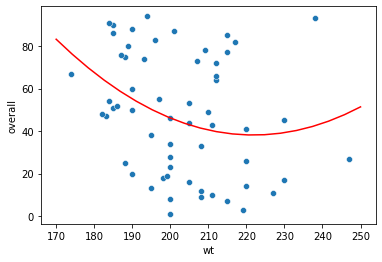

In [ ]:
# Create and fit the model 
X = np.c_[csv.wt, csv.wt**2]
model = sklearn.linear_model.LinearRegression()
model.fit(X,csv.overall)

# Make the scatter plot 
sns.scatterplot(x = csv.wt, y = csv.overall)

# Generate and plot the predicted values
p = np.linspace(170, 250, 20)
pred_x = np.c_[p, p**2]
pred_y = model.predict(pred_x)
sns.lineplot(x = p, y = pred_y, color = 'red')

# Calculate residuals (R2) and print them 
print('Training rsquared is ', model.score(X,csv.overall).round(7))


### Bootstrap confidence intervals on parameters

How confident can we be about the relation between weight and the overall ranking? 
To judge this, we need confidence intervals on the linear and quadratic coefficients. 

Write the function `BootstrapCoef` to conduct a boostrap analysis for this regression model. Input arguments to this function should be:  

* `data`, which is a dataframe having columns 'weight' and 'overall'
* `numboot` which is an integer denoting how many bootstrap replications to perform.

Write `bootstrap` to perform bootstrap resampling. You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling.  
Your function `bootstrap` should return:

- params: a numpy array of size [numboot,numParams] of bootstraped parameter values. The parameters are the intercept, the slope and the quadratic term of the linear regression model. 

*Tip: Note that the intercept can be retrieved from model.intercept_, whereas all the other regression coefficients are stored in model.coef_.* 

Read through the documentation for `pd.DataFrame.sample` ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)) to understand how to make the samples for each bootstrap run.

Then call the function to get 100 boostrap samples for your quadratic regression model of overall ability explained by weight. Make a joint scatter plot of the parameter value for the intercept and the quadratic coefficient. 

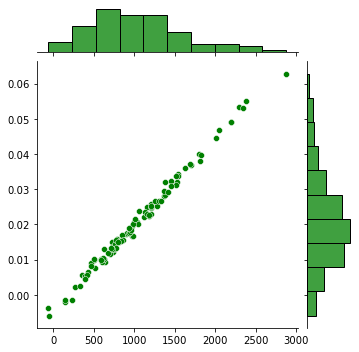

In [ ]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data, numboot):
    # Write the function here
    func = sklearn.linear_model.LinearRegression()
    mean = np.zeros((numboot, 3))
    for j in range(numboot):
        a = data.sample(len(data), replace=True)
        X_fit = np.c_[a.wt,a.wt**2]
        func.fit(X_fit,a.overall)
        mean[j,0]=func.intercept_
        mean[j,1:]=func.coef_
    return mean

# Run the function over your data
func2 = BootstrapCoef(csv[['wt', 'overall']], 100)

# Make the scatterplot
sns.jointplot(x = func2[:,0], y = func2[:,2], height = 5, color = 'green')


Make **a copy** of your data frame and subtract the mean weight from the column weight. Call the boostrap function with the modified data and provide a joint plot of the estimate for the intercept and the quadratic coefficient.  

Written answer: Compare this graph to the one from Question 2. Why do the two graphs look so different? How come the two parameters are so positively correlated in one case and nearly look independent in the other case? What is actually in common in the two cases? 

In [ ]:
# Make a copy of the csv file:
copy = csv.copy()

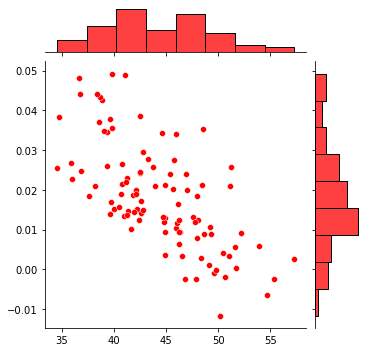

In [ ]:
# Subtract the mean weight from the weight column here
copy['wt'] = (copy['wt'] - copy['wt'].mean())

# Re-run the bootstrap algorithm over the new data here
func3 = BootstrapCoef(copy[["wt", "overall"]], 100)

# Plot the new result here:
sns.jointplot(x = func3[:,0], y = func3[:,2], height = 5, color = 'red')

**Written answer:** 

The two graphs look different because we have removed the mean of the weight (wt) from the second graph.
The correlation may have vanished because after subtracting the mean, the influence of the weight (wt) on overall is also removed. For both the jointplots, the histogram looks common.



Plot the bootstrap estimates for the quadratic coefficient as a histogram (use the estimates from the model fitted in Question 3).  Use your samples to compute a 95% confidence interval. Note that the CI should be constructed around the sample estimate of the quadratic coefficient. 

Written answer: How can you interpret this confidence interval?  

My confidence interval is between -0.01908  and  0.02952


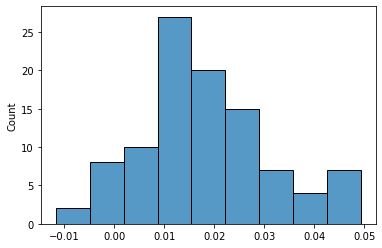

In [ ]:
# Plot histogram 
sns.histplot(func3[:,2], bins = 9)

# Calculate bootstrap interval
boot_ci = []
lower_bound = 0.05/2
upper_bound = 1 - lower_bound

boot_ci.insert(0,(np.quantile(func3[:,2] - model.coef_[1], lower_bound, axis=0)))
boot_ci.insert(1,(np.quantile(func3[:,2] - model.coef_[1], upper_bound, axis=0)) )
print('My confidence interval is between', boot_ci[0].round(5), ' and ', boot_ci[1].round(5))

In [ ]:
# Written answer:

print('This implies that the 95% of data lies in between:', boot_ci[0].round(5), 'and', boot_ci[1].round(5))

This implies that the 95% of data lies in between: -0.01908 and 0.02952



Write the function `BootstrapPred` to bootstrap your fit and generate a prediction from each of these bootstrapped models.  

Draw again a scatter plot of weight against overall ability. Plot the predictions from the 20 fitted bootstrap models to derive predictions for the weight ranging from 170 to 250. Draw all these predicted quadratic functions onto your scatter plot. 

Written answer: Where (what weight range) are we most uncertain in our prediction about the overall ability of a player? Why?

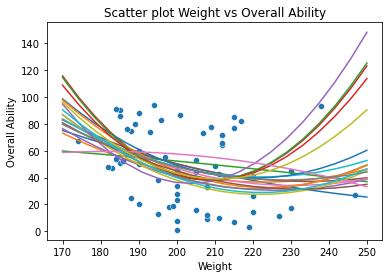

In [ ]:
# Write a Bootstrap function that records the fitted models 
def BootstrapPred(data, xp, numboot):
    func = sklearn.linear_model.LinearRegression()
    X_pred = np.c_[xp,xp**2]
    y_pred = np.zeros((numboot,X_pred.shape[0]))    
    for i in range(numboot):
        a = data.sample(len(data), replace=True)
        X_fit = np.c_[a.wt,a.wt**2]
        func.fit(X_fit,a.overall)
        y_pred[i,:]=func.predict(X_pred)
    return y_pred

# Get predictions from 20 bootstrapped models 
y_pred = BootstrapPred(csv, p, 20)

# Make a scatterplot and draw the 20 lines 
sns.scatterplot(x = csv.wt, y = csv.overall)

for j in range(20):
    sns.lineplot(p ,y_pred[j,:])
    
plt.title("Scatter plot Weight vs Overall Ability")
plt.xlabel("Weight")
plt.ylabel("Overall Ability")
plt.show()


**Written answer:**

In this prediction, the most uncertain range of weight (wt in pounds) for prediction should be the extreme ends of the weight (that is near to 170 on left and near to 250 on right end). The lines for overall ability seems to be diverging at this end making a prediction uncertain.



Now, let's see how well our model performs out of sample, i.e. for the overall ranking of hockey players in different years.  Load in the `hockey_draftees_test.csv` file into a dataframe.  
Use your fitted `model` to make predictions on the test data. **Do not refit your model using the test data.**

Make a scatter plot of the test data (weight against overall) and superimpose the prediction of the model. 
To evaluate this prediction, calculate the r-square value for the out of sample (oos) data.  Don't rely on a built-in function, but calculate the predictive r-square from the test data and your prediction directly. 

Written answer: What might explain the terrible performance of your model? 

In [ ]:
# Loading in the test file:
csv_test = pd.read_csv('hockey_draftees_test.csv')
csv_test.head(3)

,rnd,overall,draftteam,player,pos,country,wt,ht,draftyear,age,gp,playerurl
0,1,2,ANA,Bobby Ryan,RW,USA,208,74,2005,18,735,https://www.hockey-reference.com/players/r/rya...
1,1,4,MIN,Benoit Pouliot,LW,CAN,199,75,2005,18,625,https://www.hockey-reference.com/players/p/pou...
2,1,5,MTL,Carey Price,G,CAN,219,75,2005,18,561,https://www.hockey-reference.com/players/p/pri...


Out of sample rsquared is  -0.7358097599787545


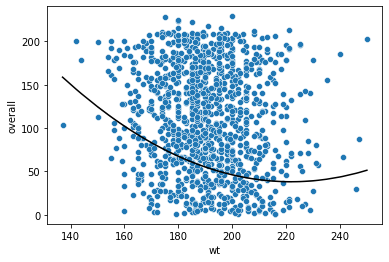

In [ ]:
# Make the scatter plot 
sns.scatterplot(csv_test["wt"], csv_test["overall"])

# Generate and plot the predicted values
x_pred = np.c_[csv_test["wt"], csv_test["wt"]**2]
y_pred = model.predict(x_pred)
sns.lineplot(x = csv_test["wt"], y = y_pred, color = "black")

# Now do the prediction for the test data and compute R2
y = csv_test.overall
mean = y.mean()
rsquared_oos = 1-(sum((y_pred - y)**2)/sum((y - mean)**2))

print('Out of sample rsquared is ', rsquared_oos)

**Written answer:**

The terrible performance may be because of no linear relationship between our variables.


In this question, you will construct a confidence interval for the sample mean, not using the normal distribution, but the t-distribution (see end of lecture 4.3), which is more accurate for small sample sizes.  

The $100(1-\alpha)\%$ confidence interval is 

$$ \bar{x} \pm  t_{1-\alpha/2, n-1} \dfrac{\hat{\sigma}}{\sqrt{n}} $$

Where $ t_{1-\alpha/2, n-1}$ is the appropiorate quantile of a Student's t distribution with $n-1$ degrees of freedom.  
Write a function called `confidence_interval` which takes as it's argument an array of data called `data` and returns two things:

* An estimated mean of `data`, and 

* The lower and upper bounds of the 95% confidence interval for the mean of `data`.  Ensure these are returned in a numpy array of shape (2,)

To get the appropirate quantiles for the t-distribution, you can use `scipy.stats.t`, which implements some statistical functions for the t-distribution.  Take a look at the documentation for `scipy.stats.t`, especially the `ppf` method.



In [ ]:
def confidence_interval(data):

    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof=1
    # Alternatively, you can use scipy.stats.sem to compute
    #The standard error
    mean = data.mean()
    se = np.std(data, ddof=1)
    sd = se/np.sqrt(len(data))
    tstat = t.ppf(0.975, len(data) - 1)
    
    confidence_interval_2 = []
    confidence_interval_2.insert(0,mean - tstat*sd)
    confidence_interval_2.insert(1,mean + tstat*sd)
    bounds = np.array(confidence_interval_2)
    
    return mean, bounds


The "95% confidence interval" is named so because the long term relative frequency of these estimators containing the true estimand is 95%.  That is to say **if I construct 100 95% confidence intervals for the sample mean again and again from the same data generating mechanism, 95 of these intervals I construct will contain the true population mean**.



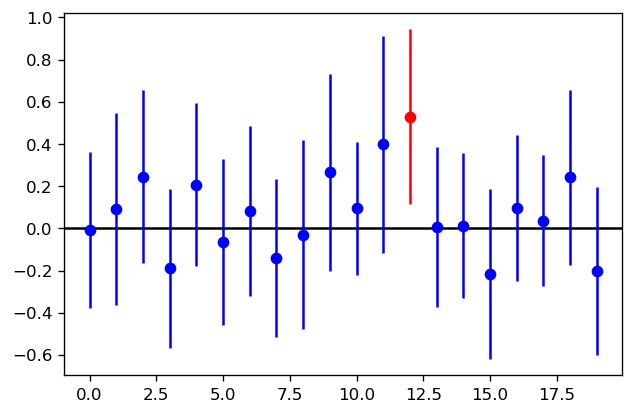

In [ ]:
def ci_simulation():
    # Set the random seed to always get the same random numbers. 
    # This is for Reproducibility. 
    np.random.seed(4)
    
    # Create the figure.
    fig, ax = plt.subplots(dpi = 120)

    # If the interval crosses this line, it should be blue, else red.
    ax.axhline(0, color = 'k')

    # Do the following 20 times
    for i in range(20):

        #Draw 25 observations from a standard normal
        o = np.random.normal(0,1,25)

        # Compute what we need for the CI, namely the mean and the bounds
        mu = confidence_interval(o)[0]
        bounds=confidence_interval(o)[1]
        
        # color should be blue if it crosses the black line
        color = 'blue'
        if (min(bounds)>0)|(max(bounds)<0):
            # but in the case it does not, turn it red
            color = 'red'

        # Need to get the length of the interval from bounds
        interval_len = 1.0/2*(bounds[1] - bounds[0])
        ax.errorbar(i, mu, yerr=interval_len, color = color, fmt = 'o')

    # This function does not have to return anything
    return None

ci_simulation()